# Access and mosaic Planet NICFI monthly basemaps

## Setup Notebook

In [1]:
!pip install -q rasterio
!pip install -q geopandas

     |████████████████████████████████| 19.3 MB 135 kB/s 
     |████████████████████████████████| 1.0 MB 8.2 MB/s 
     |████████████████████████████████| 15.4 MB 44.7 MB/s 
     |████████████████████████████████| 6.3 MB 82.2 MB/s 


In [8]:
# import required libraries
import os, glob, functools, fnmatch, requests, json
from zipfile import ZipFile
from itertools import product
from configparser import ConfigParser
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import geopandas as gpd


from IPython.display import clear_output

In [3]:
#authenticate Google Cloud Storage
from google.colab import auth
auth.authenticate_user()
print("...done")

...done


In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Set your root directory, and project level directories.
root_dir = '/content/gdrive/My Drive/servir-tf/' 
terrabio_dir = root_dir+'terrabio'
rami_dir = root_dir+'rami'

In [6]:
dirs = [root_dir, terrabio_dir, rami_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(root_dir)

In [20]:
%cd $root_dir

/content/gdrive/My Drive/servir-tf


#### Let's download the RAMI AOI vector file.

In [24]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
project = 'servirtensorflow'
storage_client = storage.Client(project=project)

# The name for the new bucket
bucket_name = "dev-seed-workshop"

rami_data_dir = rami_dir+'/data/'
rami_gcs_to_local_dir = rami_data_dir+'gcs/'
prefix = 'rami/data/Blocks/'
local_dir = rami_gcs_to_local_dir+'Blocks/'
dirs = [rami_data_dir, rami_gcs_to_local_dir, local_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)


bucket_name = "dev-seed-workshop"
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    print(blob)
    filename = blob.name.replace('/', '_') 
    filename_split = os.path.splitext(filename)
    filename_zero, fileext = filename_split
    basename = os.path.basename(filename_zero)
    filename = 'Blocks'
    blob.download_to_filename(local_dir + filename + fileext)  # Download
    print(blob, filename + fileext)

<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.cpg, 1637264951785014>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.cpg, 1637264951785014> Blocks.cpg
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.dbf, 1637264951817858>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.dbf, 1637264951817858> Blocks.dbf
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.fix, 1637264951832266>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.fix, 1637264951832266> Blocks.fix
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.prj, 1637264951801837>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.prj, 1637264951801837> Blocks.prj
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shp, 1637264951794288>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shp, 1637264951794288> Blocks.shp
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shx, 1637264951768348>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shx, 163

In [25]:
# go to RAMI directory
%cd $rami_gcs_to_local_dir 

/content/gdrive/My Drive/servir-tf/rami/data/gcs


In [26]:
!ls Blocks/

Blocks.cpg  Blocks.dbf	Blocks.fix  Blocks.prj	Blocks.shp  Blocks.shx


In [27]:
gdf = gpd.read_file('Blocks/Blocks.shp')

In [28]:
bbox_peru = gdf.geometry.total_bounds

In [30]:
#setup API KEY
config = ConfigParser()
configFilePath = '/content/gdrive/My Drive/planet_api.cfg'
with open(configFilePath) as f:
    config.read_file(f)
API_KEY = config.get('credentials', 'api_key')
PLANET_API_KEY = API_KEY # <= insert API key here 
#setup Planet base URL
API_URL = "https://api.planet.com/basemaps/v1/mosaics"
#setup session
session = requests.Session()
#authenticate
session.auth = (PLANET_API_KEY, "") #<= change to match variable for API Key if needed

In [31]:
#set params for search using name of mosaic
parameters = {
    "name__is" :"planet_medres_normalized_analytic_2021-08_mosaic" # <= customize to your use case
}
#make get request to access mosaic from basemaps API
res = session.get(API_URL, params = parameters)
#response status code
print(res.status_code)

200


In [ ]:
#print metadata for mosaic
mosaic = res.json()
print(json.dumps(mosaic, indent=2))

In [34]:
#get id
mosaic_id = mosaic['mosaics'][0]['id']
#get bbox for entire mosaic
mosaic_bbox = mosaic['mosaics'][0]['bbox']
print("mosaic_bbox: ", mosaic_bbox)
print("bbox_peru: ", bbox_peru)
#converting bbox to string for search params
string_bbox = ','.join(map(str, bbox_peru)) #bbox_peru)) #mosaic_bbox))

print('Mosaic id: '+ mosaic_id)

mosaic_bbox:  [-179.999999974944, -30.145127179527, 179.999999975056, 30.145127179625]
bbox_peru:  [-70.28418783 -13.07947054 -69.78113127 -12.75607703]
Mosaic id: ce7bad0f-a4a0-45fd-904b-eb6cc6eee373


In [ ]:
#search for mosaic quad using AOI
search_parameters = {
    'bbox': string_bbox,
    'minimal': True
}
#accessing quads using metadata from mosaic
quads_url = "{}/{}/quads".format(API_URL, mosaic_id)
res = session.get(quads_url, params=search_parameters, stream=True)
print(res.status_code)

200


In [ ]:
quads = res.json()

In [ ]:
quads

In [ ]:
quads = res.json()
items = quads['items']
#printing an example of quad metadata
print(json.dumps(items[0], indent=2))

In [ ]:
items

In [ ]:
nicfi_dir = rami_dir+'082021_basemap_nicfi_lapampa/' 

In [ ]:
#iterate over quad download links and saving to folder by id
for i in items:
    link = i['_links']['download']
    name = i['id']
    name = name + '.tiff'
    DIR = nicfi_dir+'quads/' # <= a directory i created, feel free to customize
    filename = os.path.join(DIR, name)
    #print(filename)

    #checks if file already exists before s
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(link, filename)

### Mosaic the quad tiles

In [ ]:
# File and folder paths
out_mosaic = nicfi_dir+'082021_basemap_nicfi_lapampa_Mosaic.tif'

# Make a search criteria to select the DEM files
search_criteria = "*.tiff"
q = os.path.join(nicfi_dir,'quads', search_criteria)

print(q)

/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/*.tiff


In [ ]:
# Get all of the quad tiles
quad_files = glob.glob(q)

In [ ]:
quad_files

['/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/624-950.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/625-950.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/626-950.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/627-950.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/624-949.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/625-949.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/626-949.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/627-949.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/624-948.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/625-948.tiff',
 '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/626

In [ ]:
src_files_to_mosaic = []

In [ ]:
for f in quad_files:
  src = rasterio.open(f)
  src_files_to_mosaic.append(src)

In [ ]:
src_files_to_mosaic

[<open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/624-950.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/625-950.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/626-950.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/627-950.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/624-949.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/625-949.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/626-949.tiff' mode='r'>,
 <open DatasetReader name='/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/quads/627-949.t

In [ ]:
# Create the mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

In [ ]:
out_meta = src.meta.copy()

In [ ]:
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans
                  }
)

In [ ]:
# Write the mosaic to raster file
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

In [ ]:
out_mosaic

'/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/082021_basemap_nicfi_lapampa_Mosaic.tif'

In [35]:
!ls '/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/082021_basemap_nicfi_lapampa_Mosaic.tif'

'/content/gdrive/My Drive/servir-tf/rami/082021_basemap_nicfi_lapampa/082021_basemap_nicfi_lapampa_Mosaic.tif'


#### Plot the image composite

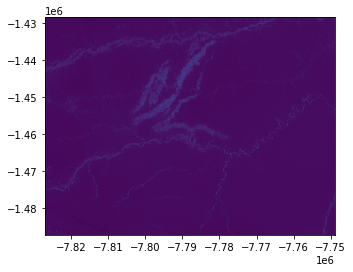

In [7]:
src = rasterio.open(out_mosaic)

show(src)